In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Read the collected data
df = pd.read_csv('Cardata_combined.csv')

#Lets change names to english
df.columns = ['Index','Car type', 'Price', 'Id', 'Yearly Check', 'Limited benefit','Model', 'Mileage','Engine','Seller','Owner amount','Updated','License plate number', 'Location', 'Power','Delivery Cost','Transmission','Manufacturer','Full Benefit','Drivetrain','Year']

#Drop if ID is empty
df = df.dropna(subset=['Index'])

#Lets drop some unnecessary columns
df=df.drop(columns=['Index', 'Id', 'Yearly Check','Owner amount','Updated','License plate number','Delivery Cost','Limited benefit','Full Benefit'])
#Lets drop the rows with NULL values
df = df.dropna(how='any',axis=0) 
df.head()

#Lets clean data, where Engine is Electric or only Bensiini or Diesel, without Engine Size information. 
#And lets give average engine size to them so we can still have them with us, but engine size wont distort the results.
df.Engine[df.Engine == 'Sähkö'] = '20 , Sähkö'
df.Engine[df.Engine == 'Diesel'] = '20 , Diesel'
df.Engine[df.Engine == 'Bensiini'] = '20 , Bensiini'

#Lets change Saab models back to text, because excel changes them to dates.
df.Model[df.Model == '09-May'] = '9-5'
df.Model[df.Model == '09-Mar'] = '9-3'

#Lets separate Engine type and size to different columns.
new = df["Engine"].str.split(",", n = 1, expand = True) 
df["Engine Size"]= new[0] 
df['Engine Size'] = df['Engine Size'].map(lambda x: str(x)[:-2])
df["Fuel type"]= new[1]   
df.drop(columns =["Engine"], inplace = True) 
df['Engine Size']=df['Engine Size'].astype('float')

#Lets create area from Location and frop City information
new = df["Location"].str.split(",", n = 1, expand = True) 
df["Area"]= new[1]
df.drop(columns =["Location"], inplace = True) 

#Lets drop cars that location is outside Finland, because the price may vary because of different tax policy
df = df[~df.Area.str.endswith("Suomen ulkopuolella")]

#Change all different company names to just Company
def change_names(x):
    if x == 'Private seller':
        return 'Private seller'
    else:
        return 'Company'
df['Seller'] = df['Seller'].apply(change_names)

#Lets see if there is null and drop those rows
df = df[pd.notnull(df['Fuel type'])]
total = df.isnull().sum().sort_values(ascending=False)

#Lets define the target attribute
target = 'Price'

#Lets change Price and Mileage from float to int
df['Price']=df['Price'].astype('int')
df['Mileage']=df['Mileage'].astype('int')
df['Power']=df['Power'].astype('int')
df['Year']=df['Year'].astype('int')



#df.head(10)
df.describe()
df.dtypes

Car type         object
Price             int32
Model            object
Mileage           int32
Seller           object
Power             int32
Transmission     object
Manufacturer     object
Drivetrain       object
Year              int32
Engine Size     float64
Fuel type        object
Area             object
dtype: object

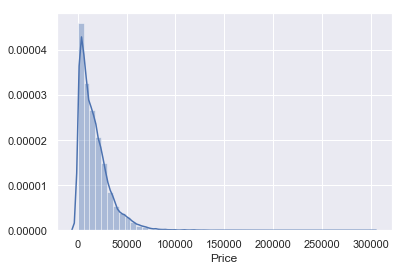

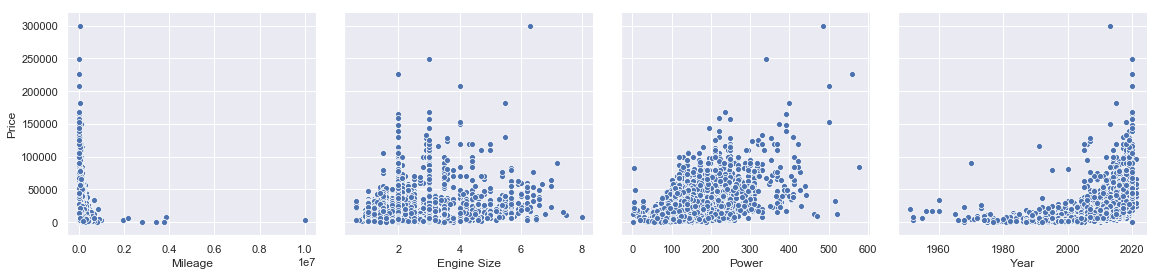

<Figure size 2880x2880 with 0 Axes>

<Figure size 2880x2880 with 0 Axes>

In [206]:
df['Price'].describe()

#histogram
sns.distplot(df['Price']);

#Scatterplot
sns.set()
#sns.pairplot(df)
sns.pairplot(df,x_vars=["Mileage","Engine Size","Power","Year"],y_vars="Price",size=4)


plt.show();

plt.figure(figsize=(40,40)) 


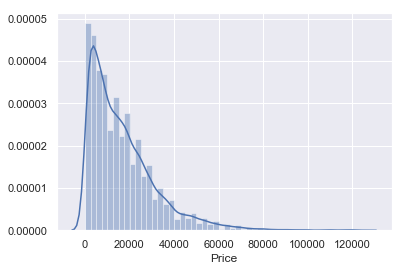

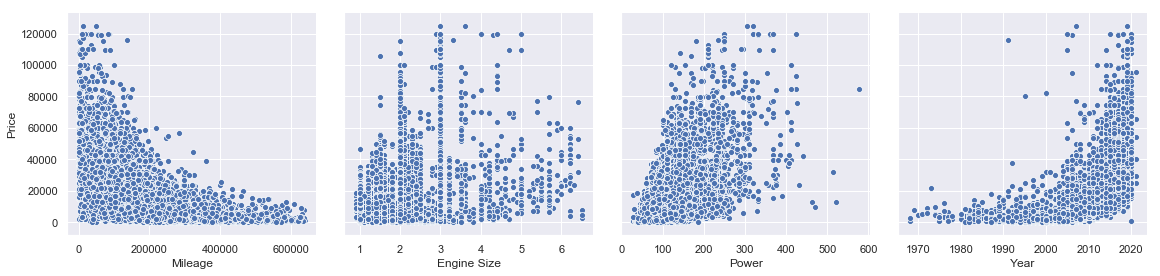

,Price,Mileage,Power,Year,Engine Size
count,19822.000000,19822.000000,19822.000000,19822.000000,19822.000000
mean,16850.687216,165094.406770,113.544042,2010.979871,1.977071
std,15181.017771,112866.544193,45.503856,6.508330,0.651115
min,100.000000,650.000000,27.000000,1968.000000,0.900000
25%,5500.000000,75000.000000,84.000000,2007.000000,1.600000
50%,12900.000000,149000.000000,105.000000,2012.000000,2.000000
75%,23800.000000,240000.000000,134.000000,2016.000000,2.100000
max,124900.000000,640000.000000,576.000000,2021.000000,6.500000


In [207]:
#Lets drop all cars that have mileage of over 650 000 km or under 650 km
df = df[~(df[['Mileage']] > 650000).all(axis=1)]
df = df[~(df[['Mileage']] < 650).all(axis=1)]

#Lets drop all cars that year model is older than 1965
df = df[~(df[['Year']] < 1965).all(axis=1)]

#Lets drop all cars that price is over 125000 € or under 100 €
df = df[~(df[['Price']] > 125000).all(axis=1)]
df = df[~(df[['Price']] < 100).all(axis=1)]

#Lets drop all cars that engine size is over 6.5 or under 0.9 Litres
df = df[~(df[['Engine Size']] > 6.5).all(axis=1)]
df = df[~(df[['Engine Size']] < 0.9).all(axis=1)]


df = df[~(df[['Power']] < 20).all(axis=1)]


sns.distplot(df['Price']);

#Scatterplot
sns.set()
sns.pairplot(df,x_vars=["Mileage","Engine Size","Power","Year"],y_vars="Price",size=4)
plt.show();

df.describe()

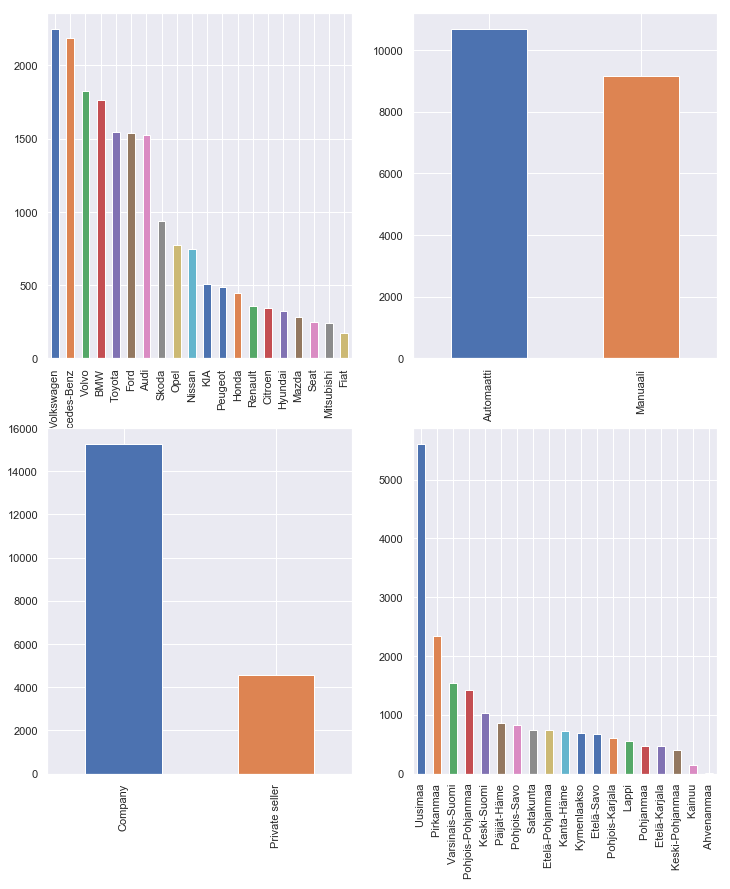

In [208]:
#Lets see how many numerical and categorical features is there
numerical_feats = df.dtypes[df.dtypes != "object"].index
categorical_feats = df.dtypes[df.dtypes == "object"].index

fig, axarr = plt.subplots(2, 2, figsize=(12, 14))

df['Manufacturer'].value_counts().head(20).plot.bar(
    ax=axarr[0][0])

df['Seller'].value_counts().sort_index().plot.bar(
    ax=axarr[1][0])

df['Transmission'].value_counts().sort_index().plot.bar(
    ax=axarr[0][1])

df['Area'].value_counts().head(20).plot.bar(
    ax=axarr[1][1])

Text(0.5, 1.0, 'Scaled data')

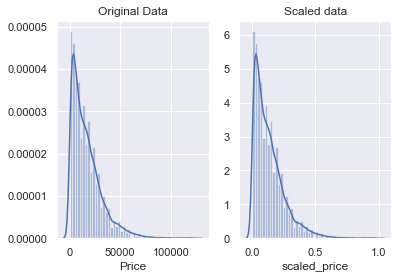

In [209]:
from mlxtend.preprocessing import minmax_scaling

#Changing data to scaled 
df['scaled_price'] = minmax_scaling(df['Price'], columns = [0])
df['scaled_mileage'] = minmax_scaling(df['Mileage'], columns = [0])
df['scaled_year'] = minmax_scaling(df['Year'], columns = [0])
df['scaled_engine_size'] = minmax_scaling(df['Engine Size'], columns = [0])
df['scaled_power'] = minmax_scaling(df['Power'], columns = [0])

#Lets create subplotgrid
fig, ax=plt.subplots(1,2)

#Plotting original data
sns.distplot(df['Price'], ax=ax[0])
ax[0].set_title("Original Data")

#Plotting scaled data
sns.distplot(df['scaled_price'], ax=ax[1])
ax[1].set_title("Scaled data")

In [210]:
#Lets decide features that we want to use
features = ['Model','Seller','Mileage','Transmission','Manufacturer','Drivetrain','Year','Engine Size','Fuel type']

#Defines price as a component what we want to know and then features which we want to use to calculate the price
y = df.Price
X = pd.get_dummies(df[features])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [211]:
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib

#Random forest regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
melb_preds = rf.predict(X_test)
filename = 'rfr_model2020.sav'
joblib.dump(model, filename)
print('Random forest accurary:',rf.score(X_test,y_test))


Random forest accurary: 0.9149334986011072


In [213]:
manufacturer = 'Toyota'
model = 'Avensis'
year = 2009
mileage = 241
fuel_type = "Diesel"
fuel_type = ' ' + fuel_type
engine_size = 2.0
drivetrain = 'Etuveto'
transmission = 'Automaatti'
seller = 'Private seller'
#power = 100

#Deletes all the files from dataframe, but leaves columns just like they were
odt=(X_test[:1])
for col in odt.columns:
    odt[col].values[:] = 0
export_csv = odt.to_csv (r'cars_dataframe2020.csv', index = None, header=True)

    
#Enter values of the car that price you want to predict.
odtmodel = 'Model_' + model
odtseller = 'Seller_' + seller
odttransimission = 'Transmission_' + transmission
odtmanufacturer = 'Manufacturer_' + manufacturer
odtdrivetrain = 'Drivetrain_' + drivetrain
odtfueltype = 'Fuel type_' + fuel_type
 
odt.loc[:, 'Year'] = year
#odt.loc[:, 'Power'] = power
odt.loc[:, 'Mileage'] = mileage
odt.loc[:, 'Engine Size'] = engine_size
odt.loc[:,  odtmodel] = 1
odt.loc[:,  odtseller] = 1
odt.loc[:,  odttransimission] = 1
odt.loc[:,  odtmanufacturer] = 1
odt.loc[:,  odtdrivetrain] = 1
odt.loc[:,  odtfueltype] = 1

try:
    price = int((rf.predict(odt)))
    print('Car price is (Without scaling)',price)
except:
    print('Maker/Model unknown to database')

Car price is (Without scaling) 13105


In [216]:
### This will ask you to enter your car details.
manufacturer = input('Manufacturer: ')
model = input('Model: ')   
year = input('Year: ')
mileage = int(input('Mileage tkm: '))
mileage = mileage * 1000

fuel_type = int(input('Fuel type: 1=Bensiini, 2=Diesel, 3=Hybridi, 4=Sähkö: '))
if fuel_type == 1:
    fuel_type = "Bensiini"
elif fuel_type == 2:
    fuel_type = "Diesel"
    
elif fuel_type == 3:
    fuel_type = "Hybridi"
elif fuel_type == 4:
    fuel_type = "Sähkö"
fuel_type = ' ' + fuel_type

#If fuel type is electric it will not ask engine size, because there is none. 
#We will use the mean size, which is 2.0 just like we did in cleaning phase.
if fuel_type == ' ' + 'Sähkö':
    engine_size = 2.0
else:
    engine_size = input('Engine size: ')

#power = int(input('Power: '))
    
drivetrain = int(input('Drivetrain: 1=Etuveto, 2=Takaveto, 3=Neliveto: '))
if drivetrain == 1:
    drivetrain = "Etuveto"
elif drivetrain == 2:
    drivetrain = "Takaveto"
elif drivetrain == 3:
    drivetrain = "Neliveto"
    
transmission = int(input('Transmission: 1=Manuaali, 2=Automaatti: '))
if transmission == 1:
    transmission = "Manuaali"
elif transmission == 2:
    transmission = "Automaatti"

seller = int(input('Private seller or Company: 1=Private seller, 2=Company: '))
if seller == 1:
    seller = "Private seller"
elif seller == 2:
    seller = "Company"

"""
Variables for manual testing purposes

manufacturer = 'Opel'
model = 'Calibra'
year = 1993
mileage = 250
fuel_type = 'Bensiini'
engine_size = 2.0
drivetrain = 'Etuveto'
transmission = 'Manuaali'
seller = 'Private seller'
"""
    
#Deletes all the files from dataframe, but leaves columns just like they were
odt=(X_test[:1])
for col in odt.columns:
    odt[col].values[:] = 0
    
#Enter values of the car that price you want to predict.
odtmodel = 'Model_' + model
odtseller = 'Seller_' + seller
odttransimission = 'Transmission_' + transmission
odtmanufacturer = 'Manufacturer_' + manufacturer
odtdrivetrain = 'Drivetrain_' + drivetrain
odtfueltype = 'Fuel type_' + fuel_type
 
odt.loc[:, 'Year'] = year
#odt.loc[:, 'Power'] = power
odt.loc[:, 'Mileage'] = mileage
odt.loc[:, 'Engine Size'] = engine_size
odt.loc[:,  odtmodel] = 1
odt.loc[:,  odtseller] = 1
odt.loc[:,  odttransimission] = 1
odt.loc[:,  odtmanufacturer] = 1
odt.loc[:,  odtdrivetrain] = 1
odt.loc[:,  odtfueltype] = 1

try:
    price = int((rf.predict(odt)))
    print("\n")
    print('Car price is (Without scaling)',price)
except:
    print('Maker/Model unknown to database')
    

Manufacturer: Saab
Model: 9-5
Year: 2001
Mileage tkm: 286
Fuel type: 1=Bensiini, 2=Diesel, 3=Hybridi, 4=Sähkö: 1
Engine size: 2.0
Drivetrain: 1=Etuveto, 2=Takaveto, 3=Neliveto: 1
Transmission: 1=Manuaali, 2=Automaatti: 1
Private seller or Company: 1=Private seller, 2=Company: 1


Car price is (Without scaling) 1419
